In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import shutil
import seaborn as sn
from os import listdir, walk, getcwd, mkdir
from os.path import isfile, join, sep
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.feature import hog
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# import resizing snippets
from conversion import *

In [3]:
# Create a fresh SVMsubdirectory structure below
# If SVM or any of SVM subdirectory exists, then it removes the SVM subdirectory and create a new SVM folder with the structure below
# 
# +---.ipynb_checkpoints
# +---data
# |   \---Coronahack-Chest-XRay-Dataset
# |       \---Coronahack-Chest-XRay-Dataset
# |           +---SVM
# |           |   +---test_modified
# |           |   +---test_unique
# |           |   +---train_modified
# |           |   \---train_unique
# |           +---test
# |           \---train
# \---__pycache__


dir_path = "data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths = ["test_modified","train_modified","test_unique","train_unique"]

i = 0
loop_count = 0
while i < 4:
    loop_count += 1
    if loop_count == 7:
        break
    try:
        path = dir_path + '/SVM/' + subpaths[i]
        os.mkdir(path)
    except FileExistsError:
        # if folder exist then try remove the whole SVM subdirectory
        print("Directory " , 'SVM/' + subpaths[i] ,  " already exists")
        try:
            shutil.rmtree(dir_path + '/SVM/')
        except OSError as e:
            print("Error: %s : %s" % (dir_path, e.strerror))
    except OSError:
        print ("Creation of the directory %s failed" % subpaths[i])
        path = dir_path + '/SVM/'
        os.mkdir(path)
    else:
        print ("Successfully created the directory %s " % subpaths[i])
        i += 1

Directory  SVM/test_modified  already exists
Creation of the directory test_modified failed
Successfully created the directory test_modified 
Successfully created the directory train_modified 
Successfully created the directory test_unique 
Successfully created the directory train_unique 


In [4]:
# Show metadata of dataset


filename = "data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
# create dict mapping image names to labels

label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [6]:
def collect_files(path, subpaths, label = False):
    """Collate paths of files (images)
    
    Args:
        path (type = string): the folder path of the images
        subpath (type = list): subdirectories of paths
        labels (type = boolean): collate corresponding labels for images. Default to False

    Returns:
        tuple (f,l) where:
            f (type = list): List of filepaths
            l (type = list): List of corresponding labels to f
    """
    f=[]
    l=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
                if label == True:
                    l.append(label_dict[file][0])
            break
    return f,l

In [7]:
def shape_rgb_or_grey(img):
    """number of rows, columns and transform image channels to string
    
    Args:
        img (image): image
    Returns:
        list (shp[0], shp[1], color) where:
        shp[0] (type = int): number of rows
        shp[1] (type = int): number of columns 
        color (type = string): img channel type (RGB or GREY)
    """
    
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''Statistical summary of element of a list of filepath (f)
    
    Args:
        f (type = list): list of image filepaths
    Returns:
        list (df_sizes, bad_images) where:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
        bad_images (type = list): images not found in meta_df (Chest_xray_Corona_Metadata)  
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]


# visualize distribution of image sizes
def df_size_plots(df_sizes):
    
    '''Plots heat map of file height and with and a histogram of image channels
    
    Args:
        df_sizes (type = dataframe): dataframe containing images attributes such as name, dataset_type, extension, color, label, heigth, width, and aspect ratio) 
    '''
    
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
--> 1-s2.0-S0929664620300449-gr3_lrg-a.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-b.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-c.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-d.jpg is not in metadata. Skipping.
--> 191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg is not in metadata. Skipping.
--> 21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg is not in metadata. Skipping.
--> 396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg is not in metadata. Skipping.
--> 3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg is not in metadata. Skipping.
--> 5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg is not in metadata. Skipping.
--> 66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg is not in metadata. Skipping.
--> 6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg is not in metadata. Skipping.
--> 925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg is not in metadata. Skipping.
--> DE488FE1-0C44-428B-B67A-0974

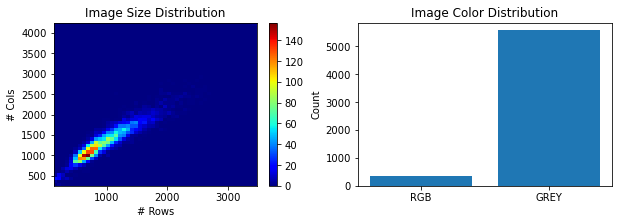

In [8]:
# Plotting the distribution of image sizes and channels in the train and test directory

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)
row_mean = df_sizes.n_rows.mean()
col_mean = df_sizes.n_cols.mean()

In [9]:
# Run conversion script on images in the train and test subdirectories.
# The conversion script applies blah blah blah to each images
# Save converted images to test_modified and train_modified subdirectories
# Only images with metadata are converted and saved

RESIZE_BOOL = False
ROWS = int(row_mean/2)
COLS = int(col_mean/2)
           
path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["test","train"]
dest_subpaths = ["SVM/test_modified","SVM/train_modified"]

for i in range(len(source_subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
####    # Same as simulation #1 except it's True, 300, True, 295. 9th input variable set to True. 10th variable set to 50. 11th variable set to 1.
    convert_image(test_path,test_destination_path,COLS,ROWS,RESIZE_BOOL,False,False,10,True,50,1,False,0.2,False,0.2,True,300,True,295,label_dict,print_every=200)

200 files processed out of 624 files.
400 files processed out of 624 files.
600 files processed out of 624 files.
--- There were 0 images without labels ---
200 files processed out of 5309 files.
400 files processed out of 5309 files.
600 files processed out of 5309 files.
800 files processed out of 5309 files.
1000 files processed out of 5309 files.
1200 files processed out of 5309 files.
1400 files processed out of 5309 files.
1600 files processed out of 5309 files.
1800 files processed out of 5309 files.
2000 files processed out of 5309 files.
2200 files processed out of 5309 files.
2400 files processed out of 5309 files.
2600 files processed out of 5309 files.
2800 files processed out of 5309 files.
3000 files processed out of 5309 files.
3200 files processed out of 5309 files.
3400 files processed out of 5309 files.
3600 files processed out of 5309 files.
3800 files processed out of 5309 files.
4000 files processed out of 5309 files.
4200 files processed out of 5309 files.
4400 fi

--- Parsing 5910 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed
--- There were 0 images not included in the metadata .csv ---


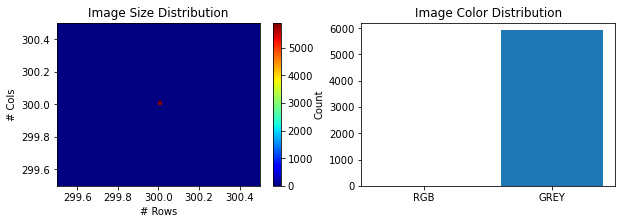

In [10]:
# Plotting the distribution of image sizes and channels for converted images.

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["SVM/test_modified","SVM/train_modified"]
f,f_label = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [11]:
# Pick one converted image per subject.
# Save the picked images in test_unique and train_unique subdirectories

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
source_subpaths=["SVM/test_modified","SVM/train_modified"]
dest_subpaths = ["SVM/test_unique","SVM/train_unique"]

for i in range(len(subpaths)):
    test_path = path + '/' +  source_subpaths[i]
    test_destination_path =  path + '/' +  dest_subpaths[i]
    list_unique_x_ray(test_path,test_destination_path,False,True,True)

1 files processed out of 415 files.
2 files processed out of 415 files.
3 files processed out of 415 files.
4 files processed out of 415 files.
5 files processed out of 415 files.
6 files processed out of 415 files.
7 files processed out of 415 files.
8 files processed out of 415 files.
9 files processed out of 415 files.
10 files processed out of 415 files.
11 files processed out of 415 files.
12 files processed out of 415 files.
13 files processed out of 415 files.
14 files processed out of 415 files.
15 files processed out of 415 files.
16 files processed out of 415 files.
17 files processed out of 415 files.
18 files processed out of 415 files.
19 files processed out of 415 files.
20 files processed out of 415 files.
21 files processed out of 415 files.
22 files processed out of 415 files.
23 files processed out of 415 files.
24 files processed out of 415 files.
25 files processed out of 415 files.
26 files processed out of 415 files.
27 files processed out of 415 files.
28 files p

291 files processed out of 415 files.
292 files processed out of 415 files.
293 files processed out of 415 files.
294 files processed out of 415 files.
295 files processed out of 415 files.
296 files processed out of 415 files.
297 files processed out of 415 files.
298 files processed out of 415 files.
299 files processed out of 415 files.
300 files processed out of 415 files.
301 files processed out of 415 files.
302 files processed out of 415 files.
303 files processed out of 415 files.
304 files processed out of 415 files.
305 files processed out of 415 files.
306 files processed out of 415 files.
307 files processed out of 415 files.
308 files processed out of 415 files.
309 files processed out of 415 files.
310 files processed out of 415 files.
311 files processed out of 415 files.
312 files processed out of 415 files.
313 files processed out of 415 files.
314 files processed out of 415 files.
315 files processed out of 415 files.
316 files processed out of 415 files.
317 files pr

162 files processed out of 2700 files.
163 files processed out of 2700 files.
164 files processed out of 2700 files.
165 files processed out of 2700 files.
166 files processed out of 2700 files.
167 files processed out of 2700 files.
168 files processed out of 2700 files.
169 files processed out of 2700 files.
170 files processed out of 2700 files.
171 files processed out of 2700 files.
172 files processed out of 2700 files.
173 files processed out of 2700 files.
174 files processed out of 2700 files.
175 files processed out of 2700 files.
176 files processed out of 2700 files.
177 files processed out of 2700 files.
178 files processed out of 2700 files.
179 files processed out of 2700 files.
180 files processed out of 2700 files.
181 files processed out of 2700 files.
182 files processed out of 2700 files.
183 files processed out of 2700 files.
184 files processed out of 2700 files.
185 files processed out of 2700 files.
186 files processed out of 2700 files.
187 files processed out o

440 files processed out of 2700 files.
441 files processed out of 2700 files.
442 files processed out of 2700 files.
443 files processed out of 2700 files.
444 files processed out of 2700 files.
445 files processed out of 2700 files.
446 files processed out of 2700 files.
447 files processed out of 2700 files.
448 files processed out of 2700 files.
449 files processed out of 2700 files.
450 files processed out of 2700 files.
451 files processed out of 2700 files.
452 files processed out of 2700 files.
453 files processed out of 2700 files.
454 files processed out of 2700 files.
455 files processed out of 2700 files.
456 files processed out of 2700 files.
457 files processed out of 2700 files.
458 files processed out of 2700 files.
459 files processed out of 2700 files.
460 files processed out of 2700 files.
461 files processed out of 2700 files.
462 files processed out of 2700 files.
463 files processed out of 2700 files.
464 files processed out of 2700 files.
465 files processed out o

752 files processed out of 2700 files.
753 files processed out of 2700 files.
754 files processed out of 2700 files.
755 files processed out of 2700 files.
756 files processed out of 2700 files.
757 files processed out of 2700 files.
758 files processed out of 2700 files.
759 files processed out of 2700 files.
760 files processed out of 2700 files.
761 files processed out of 2700 files.
762 files processed out of 2700 files.
763 files processed out of 2700 files.
764 files processed out of 2700 files.
765 files processed out of 2700 files.
766 files processed out of 2700 files.
767 files processed out of 2700 files.
768 files processed out of 2700 files.
769 files processed out of 2700 files.
770 files processed out of 2700 files.
771 files processed out of 2700 files.
772 files processed out of 2700 files.
773 files processed out of 2700 files.
774 files processed out of 2700 files.
775 files processed out of 2700 files.
776 files processed out of 2700 files.
777 files processed out o

1045 files processed out of 2700 files.
1046 files processed out of 2700 files.
1047 files processed out of 2700 files.
1048 files processed out of 2700 files.
1049 files processed out of 2700 files.
1050 files processed out of 2700 files.
1051 files processed out of 2700 files.
1052 files processed out of 2700 files.
1053 files processed out of 2700 files.
1054 files processed out of 2700 files.
1055 files processed out of 2700 files.
1056 files processed out of 2700 files.
1057 files processed out of 2700 files.
1058 files processed out of 2700 files.
1059 files processed out of 2700 files.
1060 files processed out of 2700 files.
1061 files processed out of 2700 files.
1062 files processed out of 2700 files.
1063 files processed out of 2700 files.
1064 files processed out of 2700 files.
1065 files processed out of 2700 files.
1066 files processed out of 2700 files.
1067 files processed out of 2700 files.
1068 files processed out of 2700 files.
1069 files processed out of 2700 files.


1254 files processed out of 2700 files.
1255 files processed out of 2700 files.
1256 files processed out of 2700 files.
1257 files processed out of 2700 files.
1258 files processed out of 2700 files.
1259 files processed out of 2700 files.
1260 files processed out of 2700 files.
1261 files processed out of 2700 files.
1262 files processed out of 2700 files.
1263 files processed out of 2700 files.
1264 files processed out of 2700 files.
1265 files processed out of 2700 files.
1266 files processed out of 2700 files.
1267 files processed out of 2700 files.
1268 files processed out of 2700 files.
1269 files processed out of 2700 files.
1270 files processed out of 2700 files.
1271 files processed out of 2700 files.
1272 files processed out of 2700 files.
1273 files processed out of 2700 files.
1274 files processed out of 2700 files.
1275 files processed out of 2700 files.
1276 files processed out of 2700 files.
1277 files processed out of 2700 files.
1278 files processed out of 2700 files.


1461 files processed out of 2700 files.
1462 files processed out of 2700 files.
1463 files processed out of 2700 files.
1464 files processed out of 2700 files.
1465 files processed out of 2700 files.
1466 files processed out of 2700 files.
1467 files processed out of 2700 files.
1468 files processed out of 2700 files.
1469 files processed out of 2700 files.
1470 files processed out of 2700 files.
1471 files processed out of 2700 files.
1472 files processed out of 2700 files.
1473 files processed out of 2700 files.
1474 files processed out of 2700 files.
1475 files processed out of 2700 files.
1476 files processed out of 2700 files.
1477 files processed out of 2700 files.
1478 files processed out of 2700 files.
1479 files processed out of 2700 files.
1480 files processed out of 2700 files.
1481 files processed out of 2700 files.
1482 files processed out of 2700 files.
1483 files processed out of 2700 files.
1484 files processed out of 2700 files.
1485 files processed out of 2700 files.


1765 files processed out of 2700 files.
1766 files processed out of 2700 files.
1767 files processed out of 2700 files.
1768 files processed out of 2700 files.
1769 files processed out of 2700 files.
1770 files processed out of 2700 files.
1771 files processed out of 2700 files.
1772 files processed out of 2700 files.
1773 files processed out of 2700 files.
1774 files processed out of 2700 files.
1775 files processed out of 2700 files.
1776 files processed out of 2700 files.
1777 files processed out of 2700 files.
1778 files processed out of 2700 files.
1779 files processed out of 2700 files.
1780 files processed out of 2700 files.
1781 files processed out of 2700 files.
1782 files processed out of 2700 files.
1783 files processed out of 2700 files.
1784 files processed out of 2700 files.
1785 files processed out of 2700 files.
1786 files processed out of 2700 files.
1787 files processed out of 2700 files.
1788 files processed out of 2700 files.
1789 files processed out of 2700 files.


1974 files processed out of 2700 files.
1975 files processed out of 2700 files.
1976 files processed out of 2700 files.
1977 files processed out of 2700 files.
1978 files processed out of 2700 files.
1979 files processed out of 2700 files.
1980 files processed out of 2700 files.
1981 files processed out of 2700 files.
1982 files processed out of 2700 files.
1983 files processed out of 2700 files.
1984 files processed out of 2700 files.
1985 files processed out of 2700 files.
1986 files processed out of 2700 files.
1987 files processed out of 2700 files.
1988 files processed out of 2700 files.
1989 files processed out of 2700 files.
1990 files processed out of 2700 files.
1991 files processed out of 2700 files.
1992 files processed out of 2700 files.
1993 files processed out of 2700 files.
1994 files processed out of 2700 files.
1995 files processed out of 2700 files.
1996 files processed out of 2700 files.
1997 files processed out of 2700 files.
1998 files processed out of 2700 files.


2256 files processed out of 2700 files.
2257 files processed out of 2700 files.
2258 files processed out of 2700 files.
2259 files processed out of 2700 files.
2260 files processed out of 2700 files.
2261 files processed out of 2700 files.
2262 files processed out of 2700 files.
2263 files processed out of 2700 files.
2264 files processed out of 2700 files.
2265 files processed out of 2700 files.
2266 files processed out of 2700 files.
2267 files processed out of 2700 files.
2268 files processed out of 2700 files.
2269 files processed out of 2700 files.
2270 files processed out of 2700 files.
2271 files processed out of 2700 files.
2272 files processed out of 2700 files.
2273 files processed out of 2700 files.
2274 files processed out of 2700 files.
2275 files processed out of 2700 files.
2276 files processed out of 2700 files.
2277 files processed out of 2700 files.
2278 files processed out of 2700 files.
2279 files processed out of 2700 files.
2280 files processed out of 2700 files.


2546 files processed out of 2700 files.
2547 files processed out of 2700 files.
2548 files processed out of 2700 files.
2549 files processed out of 2700 files.
2550 files processed out of 2700 files.
2551 files processed out of 2700 files.
2552 files processed out of 2700 files.
2553 files processed out of 2700 files.
2554 files processed out of 2700 files.
2555 files processed out of 2700 files.
2556 files processed out of 2700 files.
2557 files processed out of 2700 files.
2558 files processed out of 2700 files.
2559 files processed out of 2700 files.
2560 files processed out of 2700 files.
2561 files processed out of 2700 files.
2562 files processed out of 2700 files.
2563 files processed out of 2700 files.
2564 files processed out of 2700 files.
2565 files processed out of 2700 files.
2566 files processed out of 2700 files.
2567 files processed out of 2700 files.
2568 files processed out of 2700 files.
2569 files processed out of 2700 files.
2570 files processed out of 2700 files.


In [66]:
def hog_descriptor(f_paths,image = False): 
    
    '''Computes Histogram of Oriented Gradients 
    
    Args:
        f_path (type = list): list of image filepaths
        image (type = bool/list): True to capture hod image array for ALL images, list to capature only the indexes in the list
    Returns:
        tuple (hog_fd, img_dict) where:
        hog_fd (type = list): hog feature description 
        img_dict (type = list): hog image  
    '''
    
    hog_fd = []
    img_dict = {}
    i = 0
    print_every = 500
        
    for filename in f_paths:
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
    
            img = imread(filename)
            try:
                if ((image == True) or (i in image)):
                    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(9, 9), cells_per_block=(2,2 ),  transform_sqrt=True, block_norm="L1", visualize=True)
                    hog_fd.append(fd)
                    img_dict[i]= hog_image                
                else:
                    fd = hog(img, orientations=9, pixels_per_cell=(9, 9), cells_per_block=(2, 2),  transform_sqrt= True, block_norm="L1")
                    hog_fd.append(fd)

                
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except:
                print("Unknown exception occurred.") 
            
        else:
            print("Skipping {}.".format(filename))
            
    return(hog_fd, img_dict)

In [67]:
subpaths = ["SVM/train_unique"]

f_train,label_train = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in training set
hog_train, img_train = hog_descriptor(f_train,[1,2,3]) 

-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed


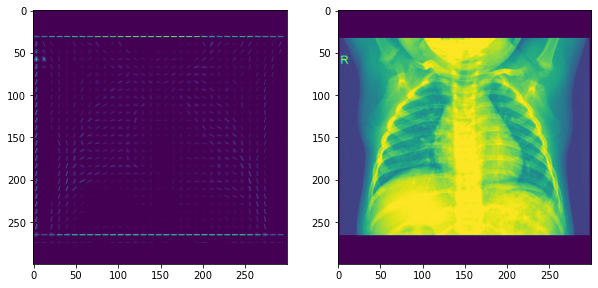

In [69]:
# Plot x-ray on the right and corresponding hog image on the left

ex_img_train = imread(f_train[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_train[2]/img_train[2].max()) 
ax[1].imshow(ex_img_train)

In [70]:
subpaths = ["SVM/test_unique"]

f_test, label_test = collect_files(path, subpaths, True)

# create hog descriptors for unique converted images in test set
hog_test, img_test = hog_descriptor(f_test, [2,3])

-> 0 images parsed


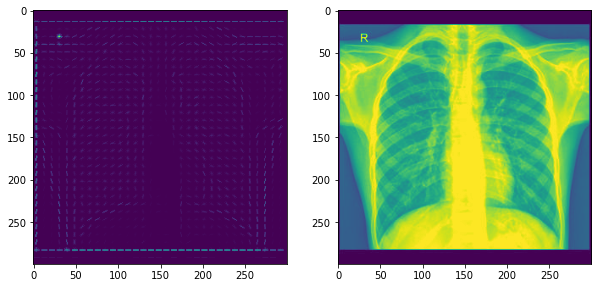

In [71]:
# Plot x-ray on the right and corresponding hog image on the left

ex_img_test = imread(f_test[2])
fig, ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_test[2]/img_test[2].max()) 
ax[1].imshow(ex_img_test)

In [72]:
def data_stack(hog_fd,label):
    ''' Creates stacked array of hog descriptors and a flattened array of their corresponding labels

    Args:
        hog_fd (type = list): list of hog feature description 
        label (list): list of labels of hog_fd
    Returns:
        tuple (X, y) where:
        X (type = array): stacked hog feature description in hog_fd  
        y (type = array): flattened array of labels of hog_fd 
    '''
    label =  np.array(label).reshape(len(label),1)
    hog_fd = np.array(hog_fd)
    
    x,y = hog_fd,label.ravel()
    return (x,y)

In [73]:
# Preprocessed training and test set

x_train,y_train = data_stack(hog_train,label_train)
x_test,y_test = data_stack(hog_test,label_test)

In [77]:
# Hyperparameter to be tuned

param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['linear','rbf', 'poly'],'probability': [True],'random_state': [7]}

In [78]:
# Standardize data
# Fit 5 folds for each of 27 combinations of hyperparameters

model = make_pipeline(StandardScaler(), GridSearchCV(SVC(),param_grid,refit=True,verbose=2, n_jobs = -1))
model.fit(x_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 92.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 465.9min finished


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=SVC(), n_jobs=-1,
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': [1, 0.1, 0.01],
                                          'kernel': ['linear', 'rbf', 'poly'],
                                          'probability': [True],
                                          'random_state': [7]},
                              verbose=2))])

In [86]:
# Create dataframe of cross-validation results of grid search

cv_rslts = pd.DataFrame(model[1].cv_results_)

In [96]:
cv_result = cv_rslts[["param_C","param_gamma","param_kernel","mean_test_score","rank_test_score"]]
cv_result.columns = ["C","Gamma","Kernel","Mean Test Score", "Model's Test Score Rank"]

In [97]:
# Display cross-validation result

cv_result.sort_values("Model's Test Score Rank")

,C,Gamma,Kernel,Mean Test Score,Model's Test Score Rank
0,0.1,1,linear,0.954074,1
24,10,0.01,linear,0.954074,1
3,0.1,0.1,linear,0.954074,1
21,10,0.1,linear,0.954074,1
6,0.1,0.01,linear,0.954074,1
18,10,1,linear,0.954074,1
9,1,1,linear,0.954074,1
15,1,0.01,linear,0.954074,1
12,1,0.1,linear,0.954074,1
23,10,0.1,poly,0.892222,10


In [89]:
# Prediction probabilities 

predictions_probs = model.predict_proba(x_test)

# Predict labels
predictions = model.predict(x_test)

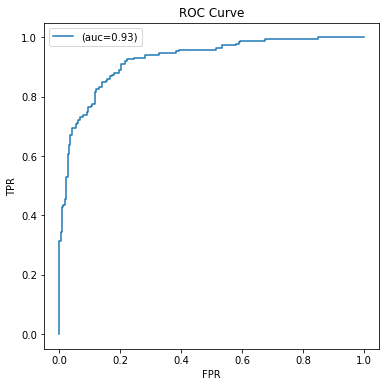

In [90]:
# Plot ROC curve

fpr, tpr,_ = metrics.roc_curve(y_test,predictions_probs[:,1] ,pos_label='Pnemonia')
auc = metrics.roc_auc_score(y_test,predictions_probs[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,label='(auc={:3.2f})'.format(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve")
plt.legend()

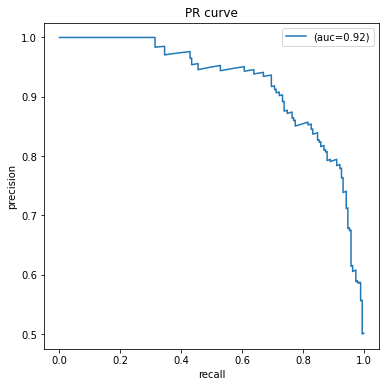

In [91]:
# Plot PR curve

prec, rec, threshs = metrics.precision_recall_curve(y_test,predictions_probs[:,1],pos_label='Pnemonia')
auc = metrics.auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec,prec,label='(auc={:3.2f})'.format(auc))
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("PR curve")
plt.legend()

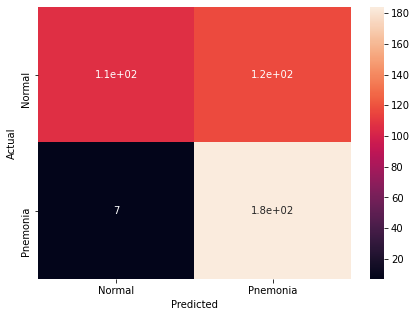

In [92]:
# Plot confusion matrix

data = {"y_test": y_test, "y_hat":predictions}
df = pd.DataFrame(data, columns=["y_test", "y_hat"])
confusion_matrix = pd.crosstab(df['y_test'],df['y_hat'],rownames=["Actual"],colnames=['Predicted'])
f, ax = plt.subplots(figsize=(7,5))
sn.heatmap(confusion_matrix, annot=True)
plt.show()